In [1]:
# coding:utf-8
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn import metrics

os.chdir('/Users/hahadsg/MyProjects/MyKaggle/house-prices-advanced-regression-techniques')
%matplotlib inline

## 参数

In [2]:
debug = False

## 函数

In [3]:
# 获取存在空的字段 以及 空值数量
def get_null_info(df):
    null_count_df = df.isnull().sum()
    return null_count_df[null_count_df > 0]

## 获取数据

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
full_df = full_df.reindex_axis(train_df.columns, axis=1) # 将columns改为原顺序
full_df = full_df.loc[:, 'MSSubClass':'SaleCondition']
full_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0          60       RL         65.0     8450   Pave   NaN      Reg   
      1          20       RL         80.0     9600   Pave   NaN      Reg   
      2          60       RL         68.0    11250   Pave   NaN      IR1   
      3          70       RL         60.0     9550   Pave   NaN      IR1   
      4          60       RL         84.0    14260   Pave   NaN      IR1   

        LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
train 0         Lvl    AllPub    Inside      ...                 0        0   
      1         Lvl    AllPub       FR2      ...                 0        0   
      2         Lvl    AllPub    Inside      ...                 0        0   
      3         Lvl    AllPub    Corner      ...                 0        0   
      4         Lvl    AllPub       FR2      ...                 0        0   

        PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
train 0    NaN   NaN         NaN       0       2    2008        WD   
      1    NaN   NaN         NaN       0       5    2007        WD   
      2    NaN   NaN         NaN       0       9    2008        WD   
      3    NaN   NaN         NaN       0       2    2006        WD   
      4    NaN   NaN         NaN       0      12    2008        WD   

         SaleCondition  
train 0         Normal  
      1         Normal  
      2         Normal  
      3        Abnorml  
      4         Normal  

[5 rows x 79 columns]

## 对房价进行log(x+1)处理
* 使分布更normal（不偏）（TODO : 但是为什么这么做呢？）
* 避免房价出现负数

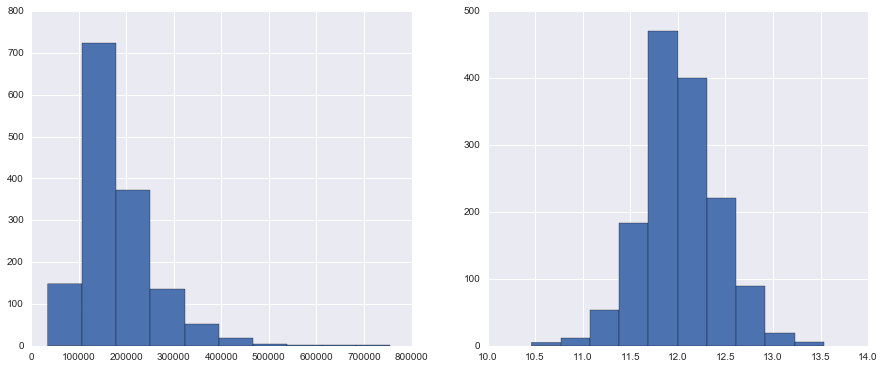

In [5]:
# 展示转换前和转换后的区别
fig, ax = plt.subplots(1, 2, figsize=(15,6))
train_df['SalePrice'].hist(bins=10, ax=ax[0])
np.log1p(train_df['SalePrice']).hist(bins=10, ax=ax[1])

# 转换
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

## 特征处理

* 连续变量

In [6]:
# 将有偏度的特征 也进行log1p操作 更normal 方便用mean填补空值 （TODO : 这个问题同上 还需要研究）
continuous_feats = full_df.dtypes[full_df.dtypes != 'object'].index
categorical_feats = full_df.dtypes[full_df.dtypes == 'object'].index

skewed_feats = train_df[continuous_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

full_df[skewed_feats] = np.log1p(full_df[skewed_feats])

In [7]:
# 缺失值用平均值填充
for feat in continuous_feats:
    full_df[feat].fillna(full_df[feat].mean(), inplace=True)

* 分类变量

In [8]:
# 将object类型做哑变量
full_df = pd.get_dummies(full_df) # get_dummies会跳过int或float类型

# for column in categorical_variable:
#     dummies_df = pd.get_dummies(full_df[column], prefix=column)
#     # 如果没有空值 哑变量就去掉一个
#     if full_df[full_df[column].isnull()][column].sum() == 0: 
#         dummies_df.drop(dummies_df.columns[-1], axis=1, inplace=True)
#     # 将哑变量放到full_df中
#     full_df = full_df.join(dummies_df) 
#     # 删掉原变量
#     full_df.drop(column, axis=1, inplace=True) 
        

## 预处理

In [9]:
full_df.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
train 0    4.110874     4.189655  9.042040            7            5   
      1    3.044522     4.394449  9.169623            6            8   
      2    4.110874     4.234107  9.328212            7            5   
      3    4.262680     4.110874  9.164401            7            5   
      4    4.110874     4.442651  9.565284            8            5   

         YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
train 0       2003          2003    5.283204    6.561031         0.0   
      1       1976          1976    0.000000    6.886532         0.0   
      2       2001          2002    5.093750    6.188264         0.0   
      3       1915          1970    0.000000    5.379897         0.0   
      4       2000          2000    5.860786    6.486161         0.0   

                 ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
train 0          ...                         0             0             0   
      1          ...                         0             0             0   
      2          ...                         0             0             0   
      3          ...                         0             0             0   
      4          ...                         0             0             0   

         SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
train 0            1                      0                      0   
      1            1                      0                      0   
      2            1                      0                      0   
      3            1                      1                      0   
      4            1                      0                      0   

         SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
train 0                     0                     0                     1   
      1                     0                     0                     1   
      2                     0                     0                     1   
      3                     0                     0                     0   
      4                     0                     0                     1   

         SaleCondition_Partial  
train 0                      0  
      1                      0  
      2                      0  
      3                      0  
      4                      0  

[5 rows x 288 columns]

In [10]:
# 分开features和label
X = full_df
y = train_df['SalePrice']

# 标准化
# X = pd.DataFrame(preprocessing.scale(X), columns=X.columns, index=X.index)
# X.head()

# train/test
if debug:
    X_train, X_test, y_train, y_test = train_test_split(X.loc['train'], y, random_state=1)
else:
    X_train = X.loc['train']
    X_test = X.loc['test']
    y_train = y
X_pred = X.loc['test']

## Lasso

In [11]:
# 对Lasso做网格化搜索
lasso_cv = GridSearchCV(Lasso(), {'alpha': np.logspace(-4,0,5)}, scoring='r2').fit(X_train, y_train)

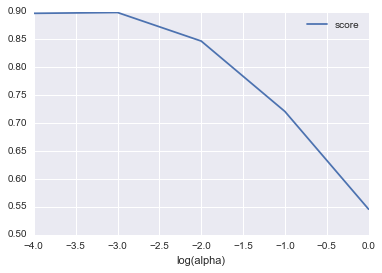

In [12]:
cv_score = [
    [
        np.log10(lasso_cv.cv_results_['params'][i]['alpha']), 
        lasso_cv.cv_results_['mean_test_score'][i],
    ] for i in range(len(lasso_cv.cv_results_['params']))
]
cv_score_df = pd.DataFrame(cv_score, columns=['log(alpha)', 'score'])
cv_score_df.set_index(['log(alpha)'], inplace=True)
cv_score_df.plot()

In [13]:
lasso = lasso_cv.best_estimator_

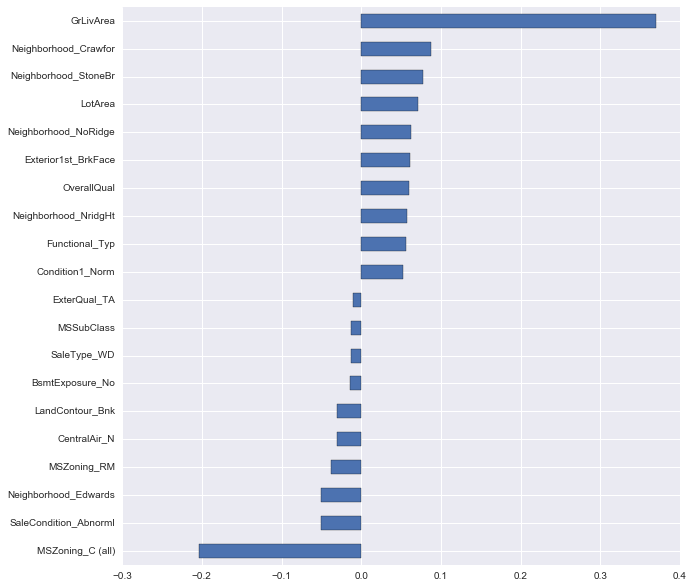

In [14]:
# 查看权重最高的系数
lasso_coef = pd.Series(lasso.coef_, index=X_train.columns)
lasso_imp_coef = pd.concat([lasso_coef.sort_values().head(10), lasso_coef.sort_values().tail(10)])
fig, ax = plt.subplots(1,1,figsize=(10,10))
lasso_imp_coef.plot(kind='barh')

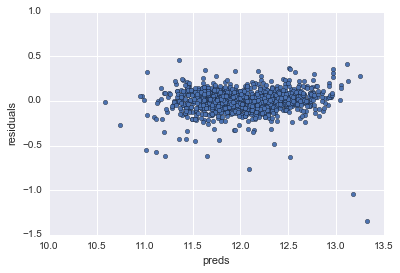

In [15]:
# 查看残差
preds = pd.DataFrame({"preds":lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [16]:
# 查看测试mse
if debug:
    print('Test Data, Lasso MSE:', metrics.mean_squared_error(lasso.predict(X_test), y_test))
print('Train Data, Lasso MSE:', metrics.mean_squared_error(lasso.predict(X_train), y_train))

Train Data, Lasso MSE: 0.0132812370463


## Lasso LARS

In [31]:
from sklearn.linear_model import LassoLars

In [35]:
lasso_lars_cv = GridSearchCV(LassoLars(), {'alpha': np.logspace(-6,0,7)}, scoring='r2').fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.785e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 83 iterations, i.e. alpha=1.878e-04, with an active set of 79 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=1.775e-04, with an active set of 85 regressors, and the sm

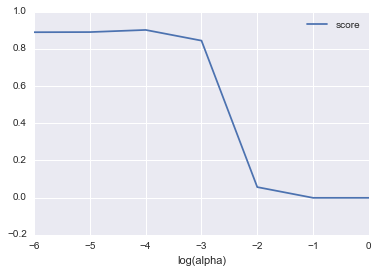

In [36]:
cv_score = [
    [
        np.log10(lasso_lars_cv.cv_results_['params'][i]['alpha']), 
        lasso_lars_cv.cv_results_['mean_test_score'][i],
    ] for i in range(len(lasso_lars_cv.cv_results_['params']))
]
cv_score_df = pd.DataFrame(cv_score, columns=['log(alpha)', 'score'])
cv_score_df.set_index(['log(alpha)'], inplace=True)
cv_score_df.plot()

In [37]:
lasso_lars = lasso_lars_cv.best_estimator_

In [38]:
# 查看测试mse
if debug:
    print('Test Data, Lasso LARS MSE:', metrics.mean_squared_error(lasso_lars.predict(X_test), y_test))
print('Train Data, Lasso LARS MSE:', metrics.mean_squared_error(lasso_lars.predict(X_train), y_train))

Train Data, Lasso LARS MSE: 0.0103364429614


## Gradient Boosting Regressor

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
model_cv_paras = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5, 7],
}
gbr_cv = GridSearchCV(GradientBoostingRegressor(), model_cv_paras).fit(X_train, y_train)

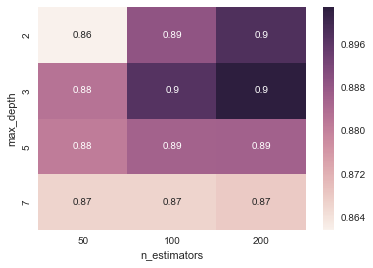

In [19]:
cv_score = [
    [
        gbr_cv.cv_results_['params'][i]['max_depth'], 
        gbr_cv.cv_results_['params'][i]['n_estimators'], 
        gbr_cv.cv_results_['mean_test_score'][i],
    ] for i in range(len(gbr_cv.cv_results_['params']))
]
cv_score_df = pd.DataFrame(cv_score, columns=['max_depth', 'n_estimators', 'score'])
cv_score_df = cv_score_df.pivot('max_depth', 'n_estimators', 'score')
sns.heatmap(cv_score_df, annot=True)

In [20]:
gbr = gbr_cv.best_estimator_

In [21]:
# 查看测试mse
if debug:
    print('Test Data, Gradient Boosting Regressor MSE:', metrics.mean_squared_error(gbr.predict(X_test), y_test))
print('Train Data, Gradient Boosting Regressor MSE:', metrics.mean_squared_error(gbr.predict(X_train), y_train))

Train Data, Gradient Boosting Regressor MSE: 0.0040406185634


## 预测 神经网络

In [22]:
# import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


In [23]:
# 每层节点数
layer_num = 4 # 层数 加上输入输出层
feature_num = len(X_train.columns)
layer_node_num = [int(x) for x in np.linspace(feature_num, 1, layer_num)]
layer_node_num

[288, 192, 96, 1]

In [24]:
# 构建模型
nn_model = Sequential()

nn_model.add(Dense(layer_node_num[0], input_dim=layer_node_num[0]))
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.6))

nn_model.add(Dense(layer_node_num[1]))
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.6))

nn_model.add(Dense(layer_node_num[2]))
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.6))

nn_model.add(Dense(layer_node_num[-1]))
nn_model.add(Activation('linear'))

nn_model.compile(loss='mse', 
#               optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
#               optimizer=SGD(lr=0.0001),
              optimizer='adam',
)

In [25]:
nn_model.fit(X_train.values, y_train.values, nb_epoch=100, batch_size=50)

Epoch 1/100
1460/1460 [==============================] - 0s - loss: 89527.9723     
Epoch 2/100
1460/1460 [==============================] - 0s - loss: 13992.1254     
Epoch 3/100
1460/1460 [==============================] - 0s - loss: 6270.6246     
Epoch 4/100
1460/1460 [==============================] - 0s - loss: 4274.5947     
Epoch 5/100
1460/1460 [==============================] - 0s - loss: 2935.3701     
Epoch 6/100
1460/1460 [==============================] - 0s - loss: 1960.6938     
Epoch 7/100
1460/1460 [==============================] - 0s - loss: 1571.3432     
Epoch 8/100
1460/1460 [==============================] - 0s - loss: 1155.0141     
Epoch 9/100
1460/1460 [==============================] - 0s - loss: 905.1762     
Epoch 10/100
1460/1460 [==============================] - 0s - loss: 764.5591     
Epoch 11/100
1460/1460 [==============================] - 0s - loss: 616.7054     
Epoch 12/100
1460/1460 [==============================] - 0s - loss: 519.1393     
Epo

In [26]:
# 查看测试mse
if debug:
    print('NNmodel MSE:', metrics.mean_squared_error(nn_model.predict(X_test.values), y_test))

In [27]:
# np.array([nn_model.predict(X_test.values).reshape(-1), y_test.values.reshape(-1)]).T

## 结果

In [40]:
# 使用的模型
res_model = lasso_lars

# 预测
y_pred = res_model.predict(X_pred.values)
y_pred = np.expm1(y_pred)

# 导出数据
res_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_pred})
res_df.to_csv('./data/result.csv', index=False)